# Faster R-CNN

https://readmedium.com/faster-rcnn-502e4a2e1ec6

https://readmedium.com/teaching-a-model-to-become-an-expert-at-locating-cats-and-dogs-in-images-716cdbc8d48f

In [1]:
!pip install -q selectivesearch
!pip install -q torch_snippets
from torch_snippets import *
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import torch
from torch import optim
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.0 MB/s eta 0:00:00


In [2]:

from google.colab import drive
drive.mount('/content/drive')

# Correct the path to the dataset
datapath = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8'



Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamidrezahazaveh","key":"01abd6b08d4ffaabca3e991cc8d2bedd"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sixhky/open-images-bus-trucks

Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
 93% 342M/367M [00:01<00:00, 244MB/s]
100% 367M/367M [00:01<00:00, 217MB/s]


In [6]:
import zipfile
import os

# Path to the downloaded zip file
with zipfile.ZipFile('open-images-bus-trucks.zip', 'r') as zip_ref:
    zip_ref.extractall('bus_trucks')

In [7]:
os.listdir('bus_trucks')

['images', 'df.csv']

In [18]:
import pandas as pd

IMAGE_ROOT = 'bus_trucks/images/images'
# Adjust the file name as needed
DF_RAW = df = pd.read_csv('bus_trucks/df.csv')
DF_RAW.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [25]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [ ]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()
class OpenDataset(Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h),resample=Image.BILINEAR))/255.
        # image = cv2.imread(img_path, 1)
        # image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # cv2.resize(img, (224,224))
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        # Convert to absolute coordinates
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        # torch FRCNN expects ground truths as
        # a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"]= torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def __len__(self):
        return len(self.image_infos)

In [ ]:
# from sklearn.model_selection import train_test_split
# trn_ids, val_ids = train_test_split(df.ImageID.unique(),test_size=0.1, random_state=99)
# trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
# train_ds = OpenDataset(trn_df)
# test_ds = OpenDataset(val_df)
# train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn,drop_last=True)
# test_loader = DataLoader(test_ds, batch_size=4,collate_fn=test_ds.collate_fn,drop_last=True)

In [ ]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# def get_model(model_path = "fasterrcnn_resnet50_before_train.pth",local_model=False):
#     if local_model:
#         model  = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False).to(device)
#         model.load_state_dict(torch.load(model_path, map_location=device))
#     else:
#         model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#         model_path = "fasterrcnn_resnet50_before_train.pth"
#         torch.save(model.state_dict(), model_path)

#     for param in model.parameters():
#         param.requires_grad = False
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
#     return model
# # model = get_model()

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the number of classes (include background as 1 class)
num_classes = 3  # Replace with your actual number of object classes (e.g., 2 objects + 1 background)

# Split dataset into training and validation
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]

# Dataset and DataLoader setup
train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

# Define the model
def get_model(num_classes):
    # Load pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the box predictor (classifier head) to match our dataset's number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model.to(device)

# Load the model with the correct number of classes
model = get_model(num_classes)

# Print the model structure (optional, for debugging)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# model = get_model(local_model= True)

In [23]:
!pip install -q torchinfo
from torchinfo import summary

# Provide a dummy input size (e.g., (3, 224, 224) for RGB images with 224x224 resolution)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [24]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

In [25]:
@torch.no_grad()
def validate_batch(inputs, model, optimizer):
    model.train()
    #to obtain losses, model needs to be in train mode only
    #Note that here we aren't defining the model's forward #method
    #hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [26]:
from torch_snippets.torch_loader import Report
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,momentum=0.9,weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

EPOCH: 1.000  val_loc_loss: 0.071  val_objectness_loss: 0.014  trn_loss: 0.186  val_regr_loss: 0.080  trn_loc_loss: 0.077  trn_regr_loss: 0.084  val_rpn_box_reg_loss: 0.009  val_loss: 0.175  trn_rpn_box_reg_loss: 0.008  trn_objectness_loss: 0.017  (2769.03s - 11076.13s remaining)
EPOCH: 2.000  val_loc_loss: 0.075  val_objectness_loss: 0.014  trn_loss: 0.157  val_regr_loss: 0.081  trn_loc_loss: 0.065  trn_regr_loss: 0.075  val_rpn_box_reg_loss: 0.009  val_loss: 0.179  trn_rpn_box_reg_loss: 0.007  trn_objectness_loss: 0.010  (5525.96s - 8288.94s remaining)
EPOCH: 3.000  val_loc_loss: 0.074  val_objectness_loss: 0.015  trn_loss: 0.145  val_regr_loss: 0.081  trn_loc_loss: 0.059  trn_regr_loss: 0.071  val_rpn_box_reg_loss: 0.009  val_loss: 0.179  trn_rpn_box_reg_loss: 0.007  trn_objectness_loss: 0.008  (8277.93s - 5518.62s remaining)
EPOCH: 4.000  val_loc_loss: 0.072  val_objectness_loss: 0.018  trn_loss: 0.141  val_regr_loss: 0.084  trn_loc_loss: 0.057  trn_regr_loss: 0.069  val_rpn_box_re

100%|██████████| 106/106 [00:00<00:00, 235.35it/s]


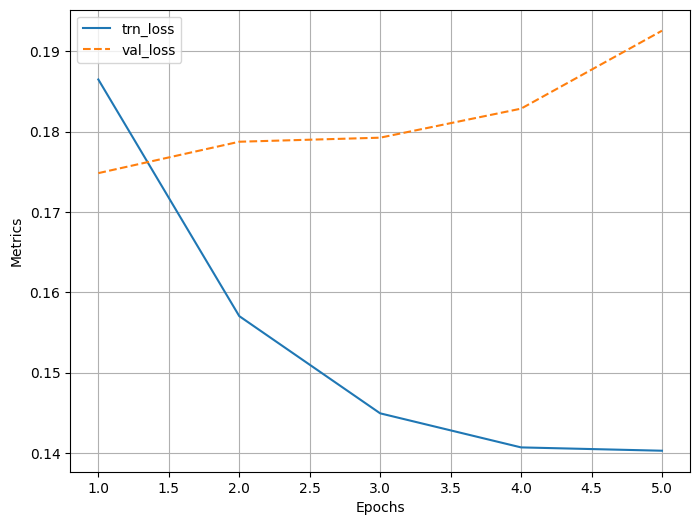

In [27]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
                 [losses[k] for k in ['loss_classifier','loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(),
        trn_loc_loss=loc_loss.item(),
        trn_regr_loss=regr_loss.item(),
        trn_objectness_loss=loss_objectness.item(),
        trn_rpn_box_reg_loss=loss_rpn_box_reg.item(),end='\r')
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model,optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(),
        val_loc_loss=loc_loss.item(),
        val_regr_loss=regr_loss.item(),
        val_objectness_loss=loss_objectness.item(),
        val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)
log.plot_epochs(['trn_loss','val_loss'])

['Bus@0.81', 'Truck@0.06']


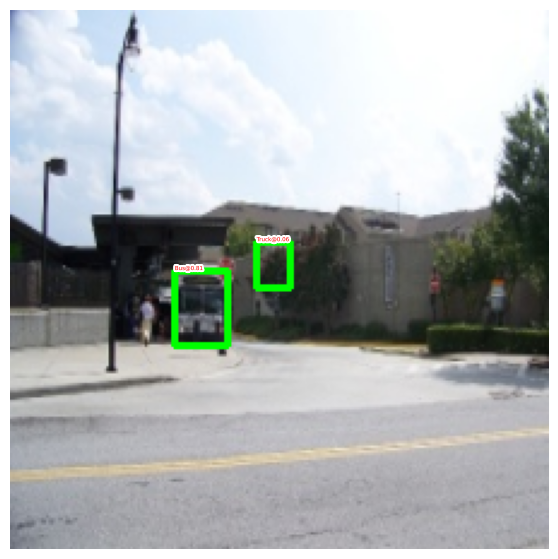

['Truck@0.91', 'Truck@0.73', 'Truck@0.69', 'Truck@0.65', 'Truck@0.48', 'Truck@0.47', 'Truck@0.32', 'Truck@0.30', 'Truck@0.30', 'Truck@0.26', 'Truck@0.25', 'Truck@0.25', 'Truck@0.24', 'Truck@0.17', 'Truck@0.11', 'Truck@0.07']


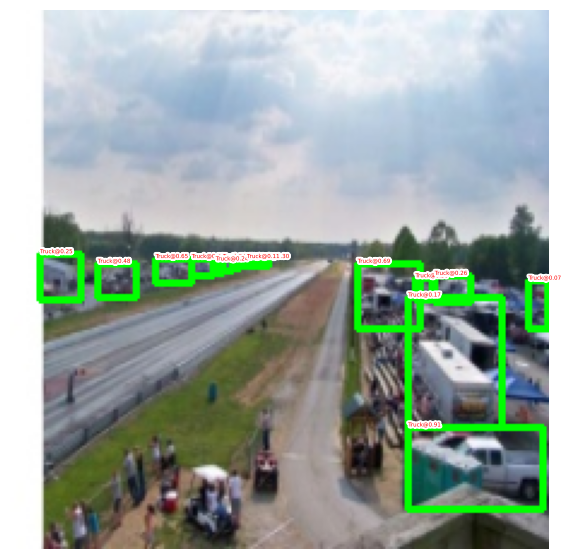

['Bus@0.97', 'Truck@0.12']


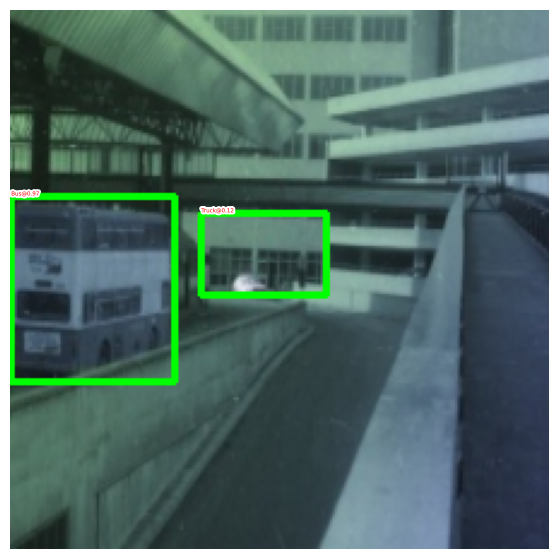

['Truck@0.74', 'Bus@0.70']


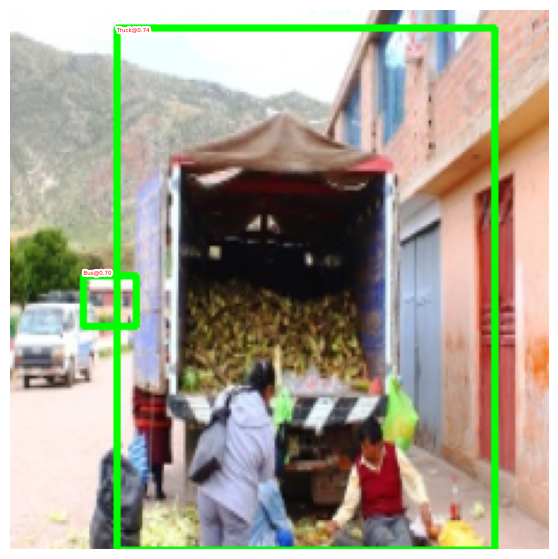

['Truck@0.98']


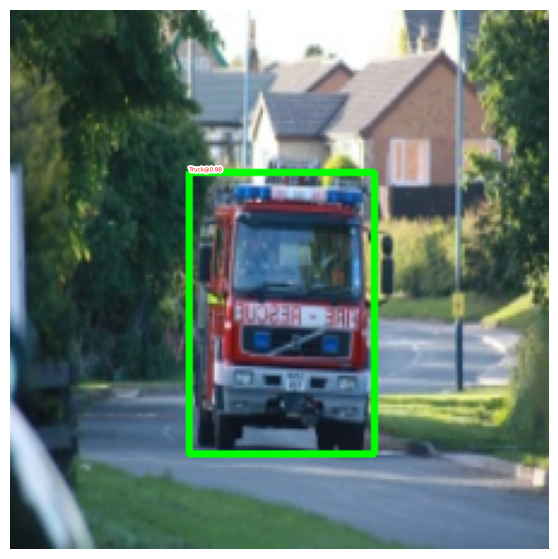

['Bus@0.91', 'Bus@0.35']


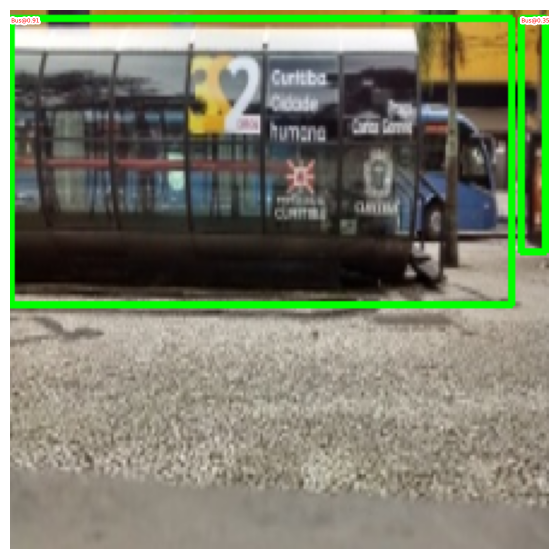

['Truck@0.78']


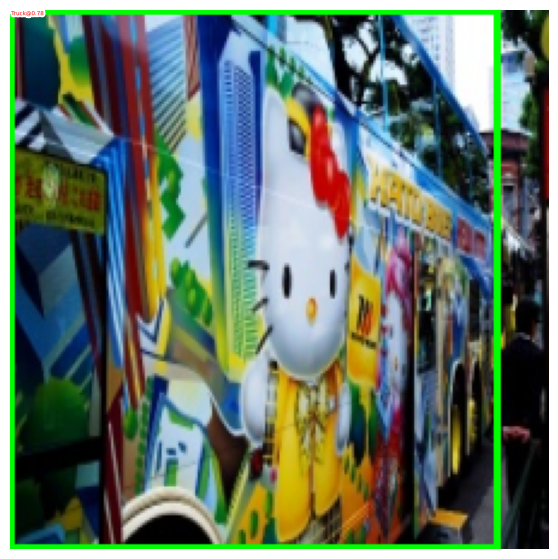

['Truck@1.00', 'Bus@0.46', 'Truck@0.41']


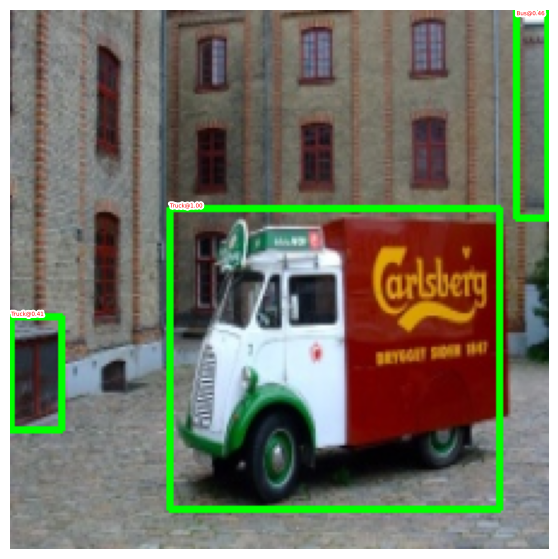

['Truck@0.46']


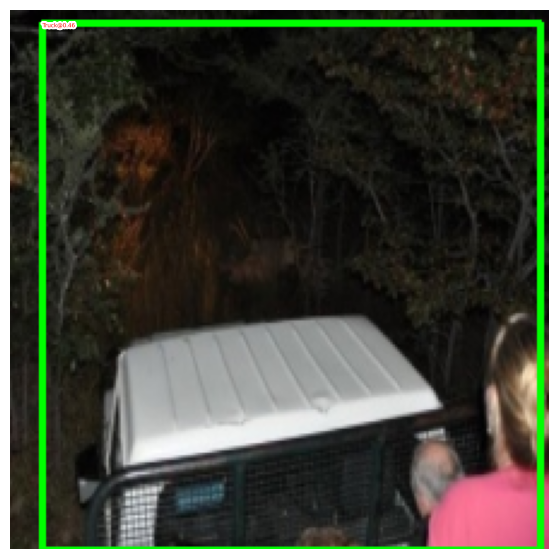

['Truck@0.93', 'Truck@0.78', 'Truck@0.64', 'Bus@0.51', 'Truck@0.06']


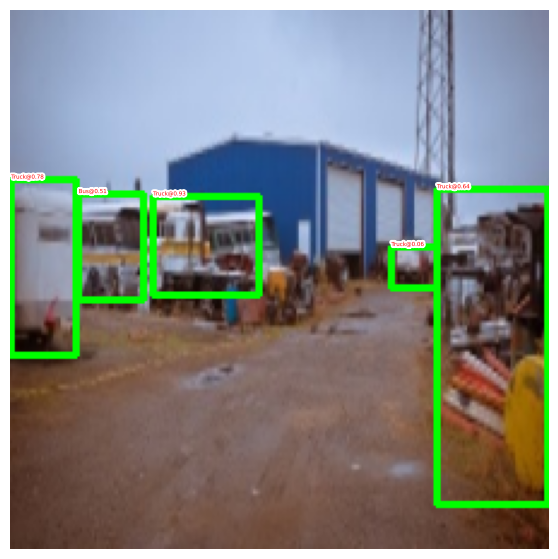

['Bus@0.92', 'Bus@0.51', 'Bus@0.15']


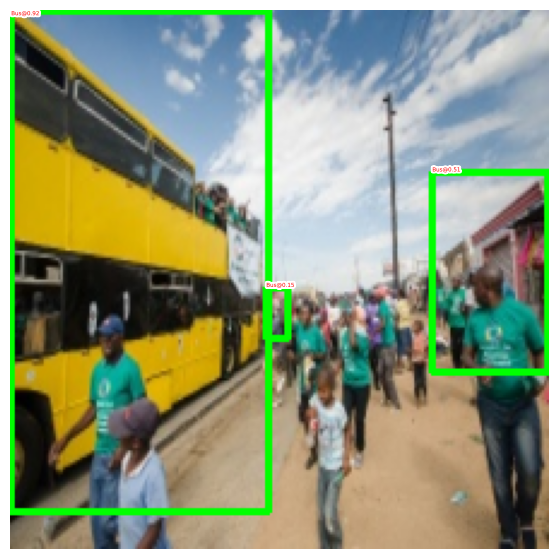

['Bus@1.00', 'Bus@0.99', 'Bus@0.97', 'Truck@0.09', 'Bus@0.06']


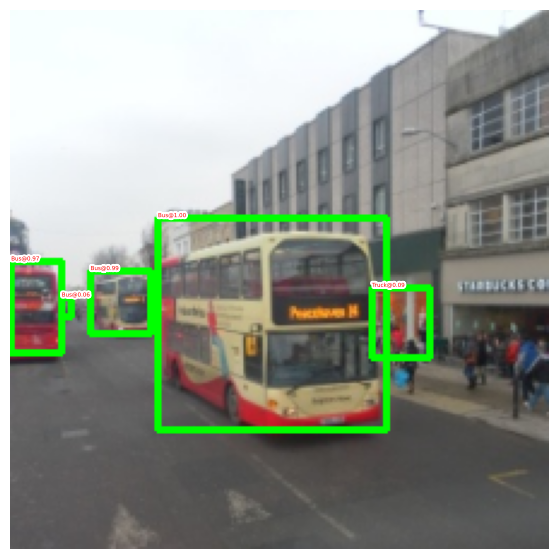

In [28]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)),torch.tensor(confs), 0.03)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
    if len(ixs) == 1:
        bbs,confs,labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels,confs)]
        print(info)
        show(images[ix].cpu().permute(1,2,0), bbs=bbs,texts=info, sz=7)

# Working details of YOLO

In [8]:
!pip install -q ultralytics
import cv2
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 16.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
model = YOLO("yolo11x.pt")

100%|██████████| 109M/109M [00:00<00:00, 273MB/s]


In [10]:
def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results

def predict_and_detect(chosen_model, img, classes=[], conf=0.5, rectangle_thickness=2, text_thickness=1):
    results = predict(chosen_model, img, classes, conf=conf)
    for result in results:
        for box in result.boxes:
            cv2.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                          (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), rectangle_thickness)
            cv2.putText(img, f"{result.names[int(box.cls[0])]}",
                        (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), text_thickness)
    return img, results

In [11]:
image = cv2.imread(r"/content/bus_trucks/images/images/0068633242ebb5da.jpg")
result_img, _ = predict_and_detect(model, image, classes=[], conf=0.5)


0: 448x640 2 persons, 4 cars, 1 bus, 134.6ms
Speed: 12.1ms preprocess, 134.6ms inference, 750.5ms postprocess per image at shape (1, 3, 448, 640)


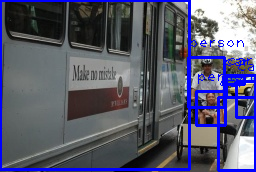

True

In [12]:
# cv2.imshow("Image", result_img)
# cv2.imwrite("result_img.jpg", result_img)
# cv2.waitKey(0)

from google.colab.patches import cv2_imshow  # Ensure this is imported
import cv2

# Display the image
cv2_imshow(result_img)

# Save the image
cv2.imwrite("result_img.jpg", result_img)




In [13]:
# defining function for creating a writer (for mp4 videos)
def create_video_writer(video_cap, output_filename):
    # grab the width, height, and fps of the frames in the video stream.
    frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_cap.get(cv2.CAP_PROP_FPS))
    # initialize the FourCC and a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    writer = cv2.VideoWriter(output_filename, fourcc, fps,
                             (frame_width, frame_height))
    return writer

In [14]:
# output_filename = "street_output.mp4"

# video_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street2.mp4"
# cap = cv2.VideoCapture(video_path)
# writer = create_video_writer(cap, output_filename)
# while True:
#     success, img = cap.read()
#     if not success:
#         break
#     result_img, _ = predict_and_detect(model, img, classes=[], conf=0.5)
#     writer.write(result_img)
#     cv2.imshow("Image", result_img)

#     cv2.waitKey(1)
# writer.release()

from google.colab.patches import cv2_imshow
import cv2

# Define the paths
video_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street2.mp4"
output_filename = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street_output.mp4"

# Open the video file
cap = cv2.VideoCapture(video_path)

# Ensure the video file is opened successfully
if not cap.isOpened():
    raise ValueError(f"Failed to open video file at {video_path}")

# Create the video writer
writer = create_video_writer(cap, output_filename)

while True:
    success, img = cap.read()
    if not success:
        break

    # Perform prediction and detection
    result_img, _ = predict_and_detect(model, img, classes=[], conf=0.5)

    # Write the processed frame to the output video
    writer.write(result_img)

    # Optionally display the frame (uncomment for debugging or visualization)
    # cv2_imshow(result_img)

# Release resources
cap.release()
writer.release()
print(f"Video processing completed. Saved to: {output_filename}")




0: 384x640 (no detections), 66.4ms
Speed: 2.1ms preprocess, 66.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 63.1ms
Speed: 1.7ms preprocess, 63.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 63.1ms
Speed: 1.7ms preprocess, 63.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 44.7ms
Speed: 1.9ms preprocess, 44.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.0ms
Speed: 2.0ms preprocess, 33.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.1ms
Speed: 1.7ms preprocess, 33.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 32.9ms
Speed: 1.5ms preprocess, 32.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.9ms
Speed: 1.4ms preprocess, 33.9ms i

https://readmedium.com/yolo11-custom-object-detection-2116db587f3b

In [15]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="Eneb4RBjEYYRdzWafAxE")
project = rf.workspace("roboflow-100").project("soccer-players-5fuqs")
version = project.version(2)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to soccer-players-2 in yolov11:: 100%|██████████| 338/338 [00:00<00:00, 9133.27it/s]


In [16]:
results = model.train(data="/content/soccer-players-2/data.yaml", epochs=3, imgsz=400)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/soccer-players-2/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=400, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.4MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]


train: Scanning /content/soccer-players-2/train/labels... 114 images, 0 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1087.68it/s]

train: New cache created: /content/soccer-players-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/soccer-players-2/valid/labels... 33 images, 0 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<00:00, 1170.68it/s]

val: New cache created: /content/soccer-players-2/valid/labels.cache


Plotting labels to /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      7.52G      3.467        3.9      1.999         34        416: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         33        407     0.0087      0.171    0.00599    0.00223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      7.96G      2.244      2.602      1.326         98        416: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         33        407      0.281       0.18      0.275      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      7.95G      1.719      1.312      1.115         78        416: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

                   all         33        407      0.623      0.315      0.305      0.174



3 epochs completed in 0.007 hours.
Optimizer stripped from /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train/weights/last.pt, 114.3MB
Optimizer stripped from /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train/weights/best.pt, 114.3MB

Validating /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


                   all         33        407      0.626      0.318      0.305      0.174
              football         28         28          1          0   0.000189   3.77e-05
                player         33        359      0.809      0.872      0.831      0.481
               referee         20         20      0.069     0.0821     0.0838     0.0414
Speed: 0.1ms preprocess, 8.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train


In [25]:
from ultralytics import YOLO

# import os
# file_path = '/usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train/weights/best.pt'
# print("File exists:", os.path.exists(file_path))

# import os
# test_images_path = "/content/datasets/test/images"
# print("Path exists:", os.path.exists(test_images_path))

model = YOLO('/usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/train/weights/best.pt')
results = model.predict(source='/content/soccer-players-2/test/images', conf=0.25, save=True)




image 1/16 /content/soccer-players-2/test/images/1-fps-2_00001_jpeg_jpg.rf.03aa7dfbdbc3d0a5482ea68a7f9a8a8d.jpg: 256x416 13 players, 51.3ms
image 2/16 /content/soccer-players-2/test/images/1-fps-2_00014_jpeg_jpg.rf.2d7d526c69632431e3d987a764cbd4e1.jpg: 256x416 5 players, 31.4ms
image 3/16 /content/soccer-players-2/test/images/1-fps-2_00022_jpeg_jpg.rf.cb129f66c83086ad73336e4c9a33fcc9.jpg: 256x416 7 players, 26.7ms
image 4/16 /content/soccer-players-2/test/images/1-fps-2_00025_jpeg_jpg.rf.c9db4792d50f6c60789177a156787289.jpg: 256x416 5 players, 26.7ms
image 5/16 /content/soccer-players-2/test/images/1-fps-2_00032_jpeg_jpg.rf.c59a43ff2bf0ca9963288bf3bd5f26d2.jpg: 256x416 6 players, 26.7ms
image 6/16 /content/soccer-players-2/test/images/1-fps-2_00041_jpeg_jpg.rf.258946c9d6d154a606aa025253f5f082.jpg: 256x416 6 players, 26.7ms
image 7/16 /content/soccer-players-2/test/images/1-fps-2_00055_jpeg_jpg.rf.51cc3c70b3e53f1e77362e14eefcd69d.jpg: 256x416 11 players, 26.7ms
image 8/16 /content/socc

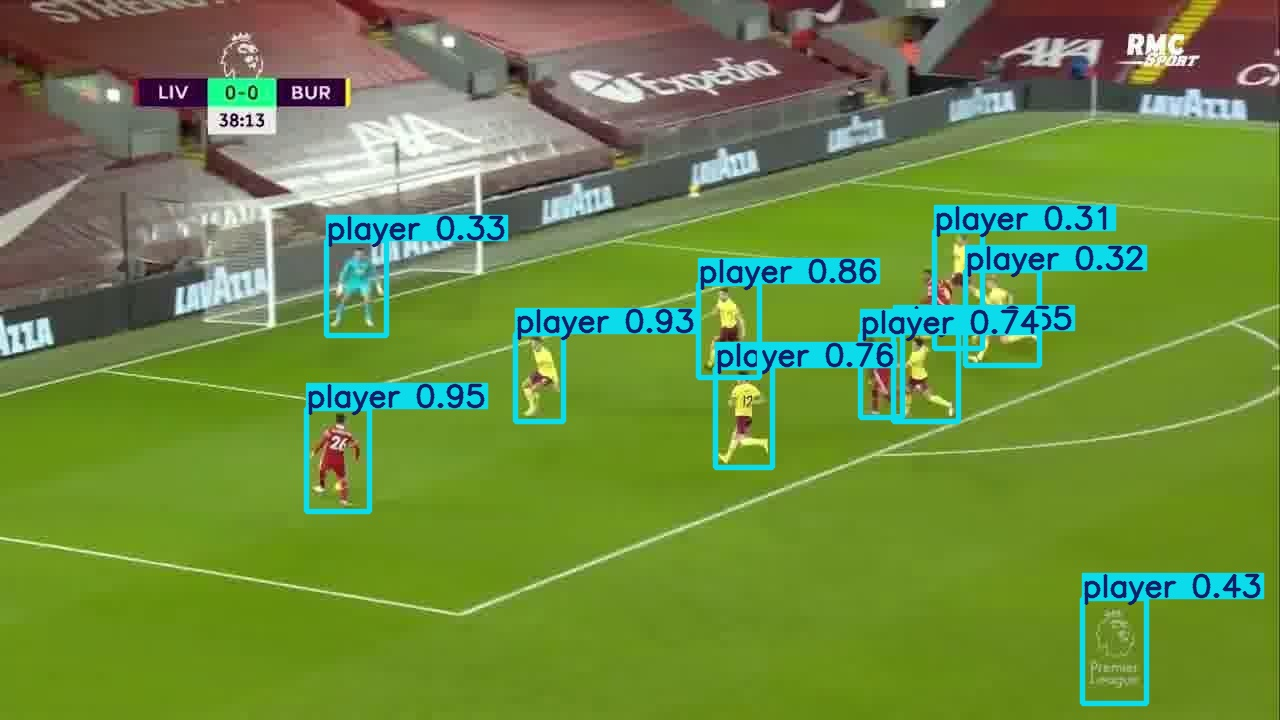

In [27]:
import glob
import os
from IPython.display import display, Image
# Find the latest prediction folder
latest_folder = max(glob.glob('/usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/predict'), key=os.path.getmtime)

# Display the first image from the latest folder
for img in glob.glob(f'{latest_folder}/*.jpg')[:1]:
    display(Image(filename=img, width=600))  # Use 'Image' here
    print("\n")